In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, ParticleFile
from parcels import AdvectionRK4, ErrorCode
import numpy as np
import xarray
from datetime import timedelta
import zipfile
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cmocean.cm as cmo

def DeleteParticle(particle, fieldset, time):
    particle.delete()

INFO: Compiled ParcelsRandom ==> /var/folders/y_/vp5v56qd4nj5b07f89_ww3fnsbfrqc/T/parcels-1924621036/libparcels_random_4042154a-f087-4dae-b4c2-ab5c21c5b236.so


In [2]:
# ds = xarray.open_zarr('/Users/hetl729/Data/Frontogenesis/surface_parent_subset.zarr',
#                       consolidated=True)
ds = xarray.open_zarr('/Users/hetl729/Data/Frontogenesis/surface_child.zarr',
                      consolidated=True)
ds = ds.sel(ocean_time=slice('2010-06-15', '2010-06-20'))

## Surface salinity kmz file

In [25]:
vmin = 25
vmax = 36.5

cmap = cmo.haline
units = 'Salinity [g/kg]'

In [16]:
kml_preamble = '''<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://earth.google.com/kml/2.1">
<Document>
  <name>Time Animation Test</name>
  <open>1</open>
  <description>
    by Rob Hetland
  </description>
  <Folder>
    <name>Frames</name>
'''

kml_frame = '''  <GroundOverlay>
      <TimeSpan>
        <begin>__TIMEBEGIN__</begin>
        <end>__TIMEEND__</end>
      </TimeSpan>
      <color>__COLOR__</color>
      <Icon>
        <href>__FRAME__</href>
      </Icon>
      <LatLonBox>
        <north>__NORTH__</north>
        <south>__SOUTH__</south>
        <east> __EAST__</east>
        <west> __WEST__</west>
      </LatLonBox>
  </GroundOverlay>
'''

kml_legend = '''<ScreenOverlay>
    <name>Legend</name>
    <Icon>
        <href>legend.png</href>
    </Icon>
    <overlayXY x="0" y="0" xunits="fraction" yunits="fraction"/>
    <screenXY x="0.015" y="0.075" xunits="fraction" yunits="fraction"/>
    <rotationXY x="0.5" y="0.5" xunits="fraction" yunits="fraction"/>
    <size x="0" y="0" xunits="pixels" yunits="pixels"/>
</ScreenOverlay>
'''

kml_closing = '''  </Folder>
</Document>
</kml>
'''

In [17]:
name = 'overlay'
color = '9effffff'
visibility = '1'
kmzfile = 'overlay.kmz'
pixels = 1000  # pixels of the max. dimension

In [19]:
# get lat/lon
lon = ds.lon_psi.values
lat = ds.lat_psi.values

# get time coordinate boundaries
dt = ds.ocean_time[1] - ds.ocean_time[0]
time_starts = ds.ocean_time.values
time_stops = np.hstack((ds.ocean_time.values[1:], ds.ocean_time[-1].values+dt))

# set aspect ratio for figure, so points are roughly even
geo_aspect = np.cos(lat.mean()*np.pi/180.0)
xsize = lon.ptp()*geo_aspect
ysize = lat.ptp()

aspect = ysize/xsize
if aspect > 1.0:
    figsize = (10.0/aspect, 10.0)
else:
    figsize = (10.0, 10.0*aspect)

Writing frame 0 2010-06-15T00:00:00.000000000, 2010-06-15T01:00:00.000000000
Writing frame 1 2010-06-15T01:00:00.000000000, 2010-06-15T02:00:00.000000000
Writing frame 2 2010-06-15T02:00:00.000000000, 2010-06-15T03:00:00.000000000
Writing frame 3 2010-06-15T03:00:00.000000000, 2010-06-15T04:00:00.000000000
Writing frame 4 2010-06-15T04:00:00.000000000, 2010-06-15T05:00:00.000000000
Writing frame 5 2010-06-15T05:00:00.000000000, 2010-06-15T06:00:00.000000000
Writing frame 6 2010-06-15T06:00:00.000000000, 2010-06-15T07:00:00.000000000
Writing frame 7 2010-06-15T07:00:00.000000000, 2010-06-15T08:00:00.000000000
Writing frame 8 2010-06-15T08:00:00.000000000, 2010-06-15T09:00:00.000000000
Writing frame 9 2010-06-15T09:00:00.000000000, 2010-06-15T10:00:00.000000000
Writing frame 10 2010-06-15T10:00:00.000000000, 2010-06-15T11:00:00.000000000
Writing frame 11 2010-06-15T11:00:00.000000000, 2010-06-15T12:00:00.000000000
Writing frame 12 2010-06-15T12:00:00.000000000, 2010-06-15T13:00:00.000000

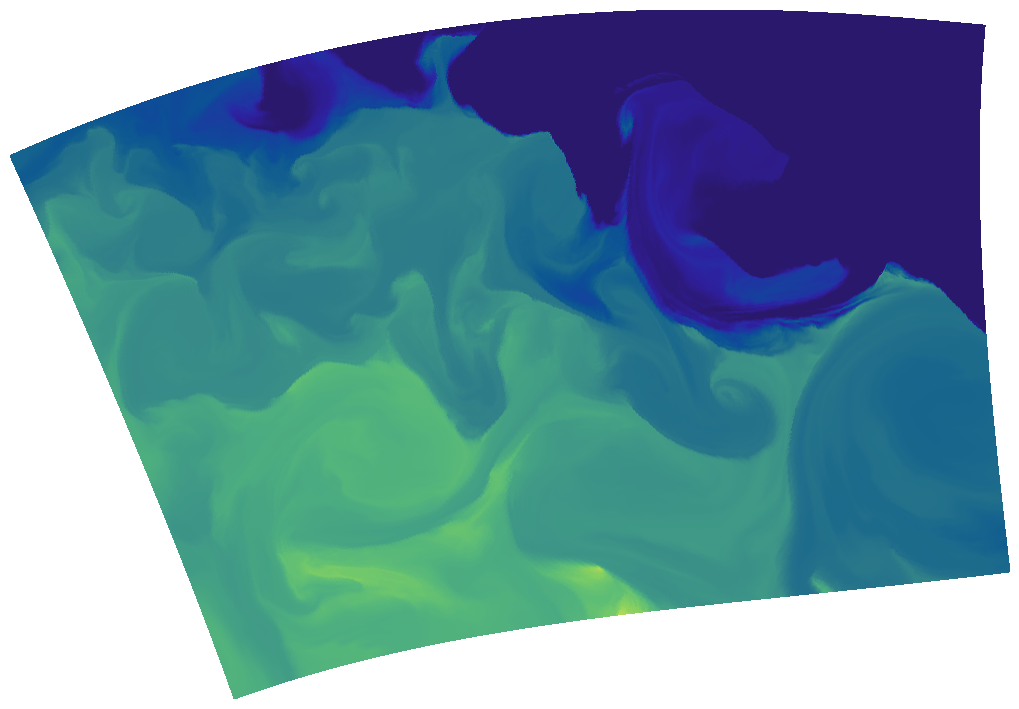

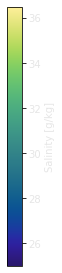

In [26]:
fig = plt.figure(figsize=figsize, dpi=pixels//10, facecolor=None, frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

f = zipfile.ZipFile('sss.kmz', 'w', compression=zipfile.ZIP_DEFLATED)

kml_text = kml_preamble

for frame in range(len(ds.ocean_time)):
    tstart =str(time_starts[frame])
    tstop = str(time_stops[frame])
    print(f'Writing frame {frame} {tstart}, {tstop}')
    ax.cla()
    pc = ax.pcolor(lon, lat, ds.salt[frame, 1:-1, 1:-1].values, 
                   vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_xlim(lon.min(), lon.max())
    ax.set_ylim(lat.min(), lat.max())
    ax.set_axis_off()
    icon = f'overlay_{frame}.png'
    plt.savefig(icon)
    kml_text += kml_frame.replace('__NAME__', name)\
                         .replace('__COLOR__', color)\
                         .replace('__VISIBILITY__', visibility)\
                         .replace('__SOUTH__', str(lat.min()))\
                         .replace('__NORTH__', str(lat.max()))\
                         .replace('__EAST__', str(lon.max()))\
                         .replace('__WEST__', str(lon.min()))\
                         .replace('__FRAME__', icon)\
                         .replace('__TIMEBEGIN__', tstart)\
                         .replace('__TIMEEND__', tstop)

    f.write(icon)
    os.remove(icon)

# legend
fig = plt.figure(figsize=(1.0, 4.0), facecolor=None, frameon=False)
cax = fig.add_axes([0.0, 0.05, 0.2, 0.90])
cb = plt.colorbar(pc, cax=cax)
cb.set_label(units, color='0.9')
for lab in cb.ax.get_yticklabels():
    plt.setp(lab, 'color', '0.9')

plt.savefig('legend.png')
f.write('legend.png')
os.remove('legend.png')

kml_text += kml_legend

kml_text += kml_closing

f.writestr('overlay.kml', kml_text)

f.close()

## Surface drifters

In [3]:
u = xarray.DataArray(data=ds.u[:, :-1, :].values,
                coords=dict(lon=(["y", "x"], ds.lon_psi.values),
                            lat=(["y", "x"], ds.lat_psi.values),
                            time=ds.ocean_time),
                dims=['ocean_time', 'y', 'x'])
v = xarray.DataArray(data=ds.v[:, :, :-1].values,
                coords=dict(lon=(["y", "x"], ds.lon_psi.values),
                            lat=(["y", "x"], ds.lat_psi.values),
                            time=ds.ocean_time),
                dims=['ocean_time', 'y', 'x'])

ds_parcels = xarray.Dataset({'u': u, 'v': v})

In [4]:
variables = {'U': 'u', 'V': 'v'}
dimensions = {'lon': 'lon', 'lat': 'lat', 'time': 'time'}
fieldset = FieldSet.from_xarray_dataset(ds_parcels, variables, dimensions, 
                                        interp_method='cgrid_velocity',
                                        gridindexingtype='nemo')

In [5]:
nparticles = 50

lon, lat = np.meshgrid(np.linspace(-94, -92, nparticles), np.linspace(28, 29, nparticles))
pset = ParticleSet(fieldset=fieldset, 
                   pclass=JITParticle,
                   lon=lon, lat=lat)   

In [6]:
output_file = pset.ParticleFile(name='tracks.nc', outputdt=timedelta(hours=1))
pset.write=True
pset.execute(AdvectionRK4,                 # the kernel (which defines how particles move)
             endtime=ds_parcels.time[-1].values,    # the total length of the run
             dt=timedelta(minutes=5),      # the timestep of the kernel
             output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}
            )

output_file.export()

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/y_/vp5v56qd4nj5b07f89_ww3fnsbfrqc/T/parcels-1924621036/5ab89632b2cfa2f539c6a6f69bcdc9ca_0.so
INFO: Temporary output files are stored in out-PGMNYKDN.
INFO: You can use "parcels_convert_npydir_to_netcdf out-PGMNYKDN" to convert these to a NetCDF file during the run.
100% (514800.0 of 514800.0) |############| Elapsed Time: 0:00:47 Time:  0:00:47


In [7]:
floats=xarray.open_dataset('tracks.nc')

In [8]:
marker_style = '''  <Style id="mystyle">
    <IconStyle>
      <scale>0.5</scale>
      <Icon>
        <href>http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png</href>
      </Icon>
    </IconStyle>
  </Style>
'''

with open(f'tracks.kml', 'w') as fp:
    fp.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    fp.write('<kml xmlns="http://www.opengis.net/kml/2.2"\n')
    fp.write('     xmlns:gx="http://www.google.com/kml/ext/2.2">\n')
    fp.write('<Folder>\n')
    fp.write(' <name>Numerical Drifter Tracks</name>\n')
    for track_id, track in floats.groupby('traj'):
        fp.write(' <Placemark>\n')
        fp.write(f'  <name></name>\n')
        fp.write(marker_style)
        fp.write('  <gx:Track>\n')
        for time in track.time:
            fp.write(f'    <when>{time.values}</when>\n')
        for lon, lat in zip(track.lon.values, track.lat.values):
            fp.write(f'    <gx:coord>{lon},{lat}</gx:coord>\n')
        fp.write('  </gx:Track>\n')
        fp.write(' </Placemark>\n')

    fp.write('</Folder>\n')
    fp.write('</kml>\n')

In [9]:
kmz_name = f'tracks.kmz'
with zipfile.ZipFile(kmz_name, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(f'tracks.kml')